# Assignment 1 - Part of Speech Tagging

## Dependencies

In [ ]:
# !pip install lightning
# !pip install torchtext.data
# !pip install torchtext
# !pip install torch

In [ ]:
# TODO: remove unused dependencies

# file management
import urllib
from pathlib import Path
import zipfile
import re
import os

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from tqdm import tqdm

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pytorch lightning
from lightning import LightningModule
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Glove and vocabulary
from torchtext.vocab import GloVe, build_vocab_from_iterator

## TASK 1: Corpus

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

### Download the corpus

In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")


def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as zip_file:
        zip_file.extractall(extract_path)

    print("Extraction completed!")

    Path.unlink(download_path)
    print("Deleted .zip dataset file")

In [ ]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")

dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, dataset_folder)


### Encode the corpus into a pandas.DataFrame object and split it into train, validation and test sets

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

In [ ]:
dataframe_rows = []
id = 0

for i, file_path in enumerate(sorted(dataset_path.iterdir())):
    if file_path.is_file():  # split corpus documents in the tree categories: train, validation, tests
        if 1 <= i + 1 <= 100:
            split = 'train'
        elif 101 <= i + 1 <= 150:
            split = 'validation'
        else:
            split = 'test'

        with file_path.open(mode='r', encoding='utf-8') as text_file:  # read corpus lines
            lines = text_file.readlines()

        for line in lines:
            fields = line.strip().split('\t')
            if len(fields) == 1:
                id = id + 1
            if len(fields) >= 2:
                text = fields[0]  # store the first field as 'text'
                POS = fields[1]  # store the second field as 'POS'
                dataframe_row = {  #build DataFrame rows
                    "text": text,
                    "POS": POS,
                    "split": split,
                    "id": id
                }

                dataframe_rows.append(dataframe_row)  #append rows
# corpus DataFrame
corpus_df = pd.DataFrame(dataframe_rows)

#### Data inspection

In [ ]:
corpus_df.head(10)

In [ ]:
print("Dataframe structure:")
print(corpus_df)
print()

print(f"Total rows {len(corpus_df)}")
print()

In [ ]:
# Train, test, validation split
df_train = corpus_df[corpus_df['split'] == 'train'].drop(columns=['split'])
df_test = corpus_df[corpus_df['split'] == 'test'].drop(columns=['split'])
df_val = corpus_df[corpus_df['split'] == 'validation'].drop(columns=['split'])

## TASK 2: Text encoding

* Embed words using **GloVe embeddings**.
* TODO: see if we want to do it, otherwise remove it -> [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [ ]:
def load_embedding_model(embedding_dimension: int = 300):
    emb_model = GloVe(name="42B", dim=embedding_dimension)
    return emb_model

In [ ]:
punctuation_and_symbol_pos = [".", ",", ":", '``', "''", "$", "#", "-LRB-", "-RRB-", "SYM", "LS"]  #TODO check "LS" 

### TASK 4.b: OOV tokens

Our vocabulary is stored in the GloVe object, and we simply edit its fields to add tokens and embedding vectors

In [ ]:
# Find training set OOV tokens
embedding_dim = 300
embedder = load_embedding_model(embedding_dim)

existing_vocab_tokens = set(embedder.itos)  # Tokens in the vocabulary, i.e. present in GloVe
train_text = set([word.lower() for word in df_train['text']])

train_oov_tokens = train_text - existing_vocab_tokens
print(f"OOV tokens in the training set: {len(train_oov_tokens)}")
print(f"Some OOV tokens: {list(train_oov_tokens)[:50]}")

In [ ]:
# Add training set OOV tokens to the GloVe embedder, sampling from a random uniform distribution for each feature in the respective range
# mins = torch.min(embedder.vectors, dim=0).values
# ranges = mins - torch.max(embedder.vectors, dim=0).values

means = torch.mean(embedder.vectors, dim=0)
stds = torch.std(embedder.vectors, dim=0)

for token in train_oov_tokens:
    embedder.itos.append(token)
    embedder.stoi[token] = len(embedder.itos) - 1
    # embedder.vectors = torch.cat((embedder.vectors, (torch.rand(embedding_dim) * ranges + mins).unsqueeze(dim=0)), dim=0)
    embedder.vectors = torch.cat((embedder.vectors, torch.normal(means, stds).unsqueeze(dim=0)), dim=0)

# For the '[UNK]' token embedding, sample a vector from a normal distribution for each feature

# Mean and std of the GloVe embeddings, for each feature
# means = torch.mean(embedder.vectors, dim=0)
# stds = torch.std(embedder.vectors, dim=0)
unk_vector = torch.normal(means, stds)

# The '[UNK]' token is not really added to the vocabulary (i.e. GloVe)
# instead, we redefine the 'unk_init' function of the embedder to return the embedding vector corresponding to '[UNK]'
embedder.unk_init = lambda x: unk_vector

print(f"New vocabulary size: {len(embedder.itos)}")

assert len(embedder.itos) == len(embedder.stoi) == embedder.vectors.shape[0]
# mean, std

### Embed words using GloVe embeddings

For the token to embedding mapping, we decided to use the following approach: the Dataset object takes care of calling the embedder every time it is queried to return a datapoint (\_\_getitem\_\_ method)

In [ ]:
iterator = ([pos] for pos in corpus_df["POS"].unique())
pos_vocab = build_vocab_from_iterator(iterator)
pos_vocab.append_token("<PAD>")

pos_padding_value = pos_vocab["<PAD>"]
punctuation_and_symbol_pos_indices = [pos_vocab[token] for token in punctuation_and_symbol_pos]


class CorpusDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, embedder):
        min_id = dataframe['id'].min()
        dataframe['id'] = dataframe['id'] - min_id
        self.dataframe = dataframe.groupby("id")
        self.embedder = embedder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sentence = self.dataframe.get_group(idx)
        text = sentence['text'].to_list()
        text = [token.lower() for token in text]

        POS = sentence['POS'].to_list()
        POS = torch.Tensor([pos_vocab[token] for token in POS])

        embedded_text = self.embedder.get_vecs_by_tokens(text)

        return embedded_text, POS


In [ ]:
# Definition of the dataset
dataset_train = CorpusDataset(df_train, embedder)
dataset_test = CorpusDataset(df_test, embedder)
dataset_val = CorpusDataset(df_val, embedder)
dataset_all = CorpusDataset(corpus_df, embedder)  # TODO: remove if not used


# This collate function takes care of adding padding to the sequences
# TODO - test if it works in the LSTM training
def my_collate(batch):
    sequences, labels = zip(*batch)

    # max_len = max([len(seq) for seq in sequences])
    # sequences_padded = [seq + ["<PAD>"] * (max_len - len(seq)) for seq in sequences]

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=pos_padding_value)

    sequences_padded = sequences_padded.type(torch.float)
    labels_padded = labels_padded.type(torch.long)

    return [sequences_padded, labels_padded]


train_loader = DataLoader(dataset_train, batch_size=32, collate_fn=my_collate)
val_loader = DataLoader(dataset_val, batch_size=32, collate_fn=my_collate)
test_loader = DataLoader(dataset_test, batch_size=32, collate_fn=my_collate)

## TASK 4: Metrics

* Evaluate models using macro F1-score, computed over **all** tokens.

We defined our own macro F1-score metric in order to accumulate FP, TP, FN, TN iteratively

In [ ]:
from torchmetrics import Metric
from torchmetrics import ConfusionMatrix


class F1ScoreCustom(Metric):
    def __init__(self, num_classes: int, pos_padding_value: int = pos_padding_value,
                 punctuation_and_symbol_pos_indices: list = punctuation_and_symbol_pos_indices):
        super().__init__()

        self.num_classes = num_classes
        self.mask = torch.ones([num_classes], dtype=torch.bool)
        self.mask[[pos_padding_value] + punctuation_and_symbol_pos_indices] = 0

        self.add_state("true_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_negative", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")

    def update(self, y_hat_class: torch.Tensor, y_class: torch.Tensor):
        confusion_matrix_metric = ConfusionMatrix(num_classes=self.num_classes, task="multiclass")
        confusion_matrix = confusion_matrix_metric(y_hat_class, y_class)

        # # Confusion matrix, TP, FN and FP for class 0 
        # #   TRUE LABEL
        # #   0               TP     FN     FN     FN     FN       
        # #   1               FP       
        # #   2               FP               
        # #   3               FP                       
        # #   4               FP                                
        # # PREDICTED LABEL   0       1      2      3      4
        # 

        true_positive = torch.Tensor([confusion_matrix[i][i] for i in range(self.num_classes)])
        false_negative = torch.Tensor([sum(confusion_matrix[i, :]) - true_positive[i] for i in range(self.num_classes)])
        false_positive = torch.Tensor([sum(confusion_matrix[:, i]) - true_positive[i] for i in range(self.num_classes)])

        self.true_positive += true_positive
        self.false_negative += false_negative
        self.false_positive += false_positive

    def compute(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)

        f1 = 2 * (precision * recall) / (precision + recall)

        return f1[self.mask]

        # f1 = f1 * self.mask

        # return f1



## TASK 3: Model definition

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

### Baseline model: Bidirectional LSTM + Dense layer

In [ ]:
class BiLSTMModel(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, target_padding_value=pos_padding_value):
        super(BiLSTMModel, self).__init__()

        self.save_hyperparameters()

        self.output_dim = output_dim
        self.target_padding_value = target_padding_value

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplied by 2 due to the bidirectionality

        self._train_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._val_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._test_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)

    def forward(self, x):
        # embedding = self.embedding_layer(x)
        lstm_out, _ = self.lstm(x)
        # lstm_out (batch_size, seq_length, hidden_size * 2)
        out = self.fc(lstm_out)
        # out (batch_size, seq_length, output_dim)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # (batch_size, seq_length, output_dim)

        # Change shape from (batchsize, sequence_len, classes) to be (batchsize, classes, sequence_len) to compute loss function
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'train_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True,
                      on_step=False, reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._train_f1_metric.update(y_hat_class, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)
        self.log_dict({'val_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._val_f1_metric.update(y_hat_class, y)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'test_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._test_f1_metric.update(y_hat_class, y)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def _compute_f1(self, f1_metric):
        mean_f1_score = f1_metric.compute()

        # Create a mask that is False for NaNs
        mask = torch.isnan(mean_f1_score)

        # Invert the mask: True for valid entries, False for NaNs
        valid_data = mean_f1_score[~mask]

        # Compute the mean of the non-NaN values
        mean_value = torch.mean(valid_data)

        return mean_value

    def on_train_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._train_f1_metric)
        self.log_dict({"train_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._train_f1_metric.reset()

    def on_validation_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._val_f1_metric)
        self.log_dict({"val_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._val_f1_metric.reset()

    def on_test_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._test_f1_metric)
        self.log_dict({"test_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._test_f1_metric.reset()


### Model 1: Bidirectional 2-layers LSTM + Dense layer

In [ ]:
class Model1(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, target_padding_value=pos_padding_value):
        super(Model1, self).__init__()

        self.save_hyperparameters()

        self.output_dim = output_dim
        self.target_padding_value = target_padding_value

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplied by 2 due to the bidirectionality

        self._train_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._val_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._test_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)

    def forward(self, x):
        # embedding = self.embedding_layer(x)
        lstm_out, _ = self.lstm(x)
        # lstm_out (batch_size, seq_length, hidden_size * 2)
        out = self.fc(lstm_out)
        # out (batch_size, seq_length, output_dim)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Change shape from (batchsize, sequence_len, classes) to be (batchsize, classes, sequence_len) to compute loss function
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'train_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True,
                      on_step=False, reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._train_f1_metric.update(y_hat_class, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)
        self.log_dict({'val_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._val_f1_metric.update(y_hat_class, y)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'test_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._test_f1_metric.update(y_hat_class, y)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def _compute_f1(self, f1_metric):
        mean_f1_score = f1_metric.compute()

        # Create a mask that is False for NaNs
        mask = torch.isnan(mean_f1_score)

        # Invert the mask: True for valid entries, False for NaNs
        valid_data = mean_f1_score[~mask]

        # Compute the mean of the non-NaN values
        mean_value = torch.mean(valid_data)

        return mean_value

    def on_train_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._train_f1_metric)
        self.log_dict({"train_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._train_f1_metric.reset()

    def on_validation_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._val_f1_metric)
        self.log_dict({"val_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._val_f1_metric.reset()

    def on_test_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._test_f1_metric)
        self.log_dict({"test_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._test_f1_metric.reset()

### Model 2: Bidirectional LSTM + 2 Dense layers

In [ ]:
class Model2(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, fc_size,
                 target_padding_value=pos_padding_value):
        super(Model2, self).__init__()

        self.save_hyperparameters()
        
        self.output_dim = output_dim
        self.target_padding_value = target_padding_value

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.fc_1 = nn.Linear(hidden_dim * 2, fc_size)  # Multiplied by 2 due to bidirectionality
        self.fc_2 = nn.Linear(fc_size, output_dim)

        self._train_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._val_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._test_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)

    def forward(self, x):
        # embedding = self.embedding_layer(x)
        lstm_out, _ = self.lstm(x)
        # lstm_out (batch_size, seq_length, hidden_size * 2)
        out = self.fc_1(lstm_out)
        out = self.fc_2(out)
        # out (batch_size, seq_length, output_dim)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Change shape from (batchsize, sequence_len, classes) to be (batchsize, classes, sequence_len) to compute loss function
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'train_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True,
                      on_step=False, reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._train_f1_metric.update(y_hat_class, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)
        self.log_dict({'val_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._val_f1_metric.update(y_hat_class, y)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'test_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._test_f1_metric.update(y_hat_class, y)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def _compute_f1(self, f1_metric):
        mean_f1_score = f1_metric.compute()

        # Create a mask that is False for NaNs
        mask = torch.isnan(mean_f1_score)

        # Invert the mask: True for valid entries, False for NaNs
        valid_data = mean_f1_score[~mask]

        # Compute the mean of the non-NaN values
        mean_value = torch.mean(valid_data)

        return mean_value

    def on_train_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._train_f1_metric)
        self.log_dict({"train_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._train_f1_metric.reset()

    def on_validation_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._val_f1_metric)
        self.log_dict({"val_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._val_f1_metric.reset()

    def on_test_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._test_f1_metric)
        self.log_dict({"test_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._test_f1_metric.reset()

## TASK 5: Training and Evaluation

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [ ]:
# Fix all possible sources of randomness
torch.use_deterministic_algorithms(True)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Training and evaluation

#### Training all models on training set and evalutating on validation set at every epoch s.t. to keep the best model for each model/seed pair.
#### Both cross entropy loss and F1-Score are computed at each evaluation

In [ ]:
logs_path = Path.cwd() / "logs" / "lightning_logs"
train = True

seeds = [6]

epochs = 100
output_dim = len(df_train["POS"].unique()) + 1  # +1 for padding
hidden_dim = 128
input_dim = embedding_dim

model_classes = [BiLSTMModel, Model1, Model2]
model_names = ["baseline", "model1", "model2"]
hyperparameters = [
    {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'output_dim': output_dim},
    {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'output_dim': output_dim},
    {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'output_dim': output_dim, 'fc_size': 64}
]

if train:
    for model_class, model_name, hyperparameter in zip(model_classes, model_names, hyperparameters):
        for seed in seeds:
            print(f"Training model {model_name} with seed {seed}...")
            seed_everything(seed, workers=True)

            model = model_class(**hyperparameter)

            logger = TensorBoardLogger(logs_path, name=f"{model_name}_seed{seed}_emb{embedding_dim}")
            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath=None,
                filename=f'{model_name}-seed={seed}' + '-{epoch:02d}-{val_loss:.2f}-{val_f1:.2f}',
                save_top_k=1,
            )
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=3,
                verbose=True,
                mode='min'
            )

            trainer = Trainer(
                max_epochs=epochs,
                logger=logger,
                log_every_n_steps=1,
                callbacks=[checkpoint_callback, early_stop_callback],
                deterministic=True
            )

            trainer.fit(model, train_loader, val_loader)
else:
    print("Skipping training...")

### Robust estimation across seeds and choice of best model

#### Compute mean and standard deviation of the validation F1Score across seeds, for each of the 3 models

In [ ]:
def mean_and_std_f1score(f1_scores: list):
    mean_f1_score = torch.mean(torch.Tensor(f1_scores))
    std_f1_score = torch.std(torch.Tensor(f1_scores))

    return mean_f1_score, std_f1_score


logs_path = Path.cwd() / "logs" / "lightning_logs"  #TODO: remove

model_names = ["baseline", "model1", "model2"]  #TODO: remove

# Iterate log directory and retrieve f1 scores for every model
val_f1_scores = {}

best_model_params = {
    "model_path": None,
    "model_name": None,
}
best_f1_score = 0

for model_name in model_names:
    val_f1_scores[model_name] = []

    for root, dirs, files in os.walk(logs_path):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('.ckpt') and model_name in file_path:
                f1_score = float(re.search(r'val_f1=(\d\.\d+)', file_path).group(1))
                val_f1_scores[model_name].append(f1_score)

                if f1_score > best_f1_score:
                    best_model_params = {
                        "model_path": file_path,
                        "model_name": model_name,
                    }
                    best_f1_score = f1_score

In [ ]:
val_f1_scores, best_model_params

## TASK 6: Error analysis

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible) 
* Comment about errors and propose possible solutions on how to address them.

### Load the best mode and evaluate it on the test set

In [ ]:
def load_model(model_name, model_path):
    if model_name == "baseline":
        cls = BiLSTMModel
    elif model_name == "model1":
        cls = Model1
    elif model_name == "model2":
        cls = Model2
    else:
        raise ValueError(f"Model name {model_name} not recognized.")
    hparams_path = Path(model_path).parent.parent / "hparams.yaml"
    model = cls.load_from_checkpoint(model_path, hparams_file=hparams_path)
    model.freeze()
    return model\

best_model = load_model(best_model_params["model_name"], best_model_params["model_path"])
best_model

In [ ]:
trainer = Trainer(deterministic=True)
test_res = trainer.test(best_model, dataloaders=test_loader)
val_res = trainer.validate(best_model, dataloaders=val_loader)

test_res, val_res

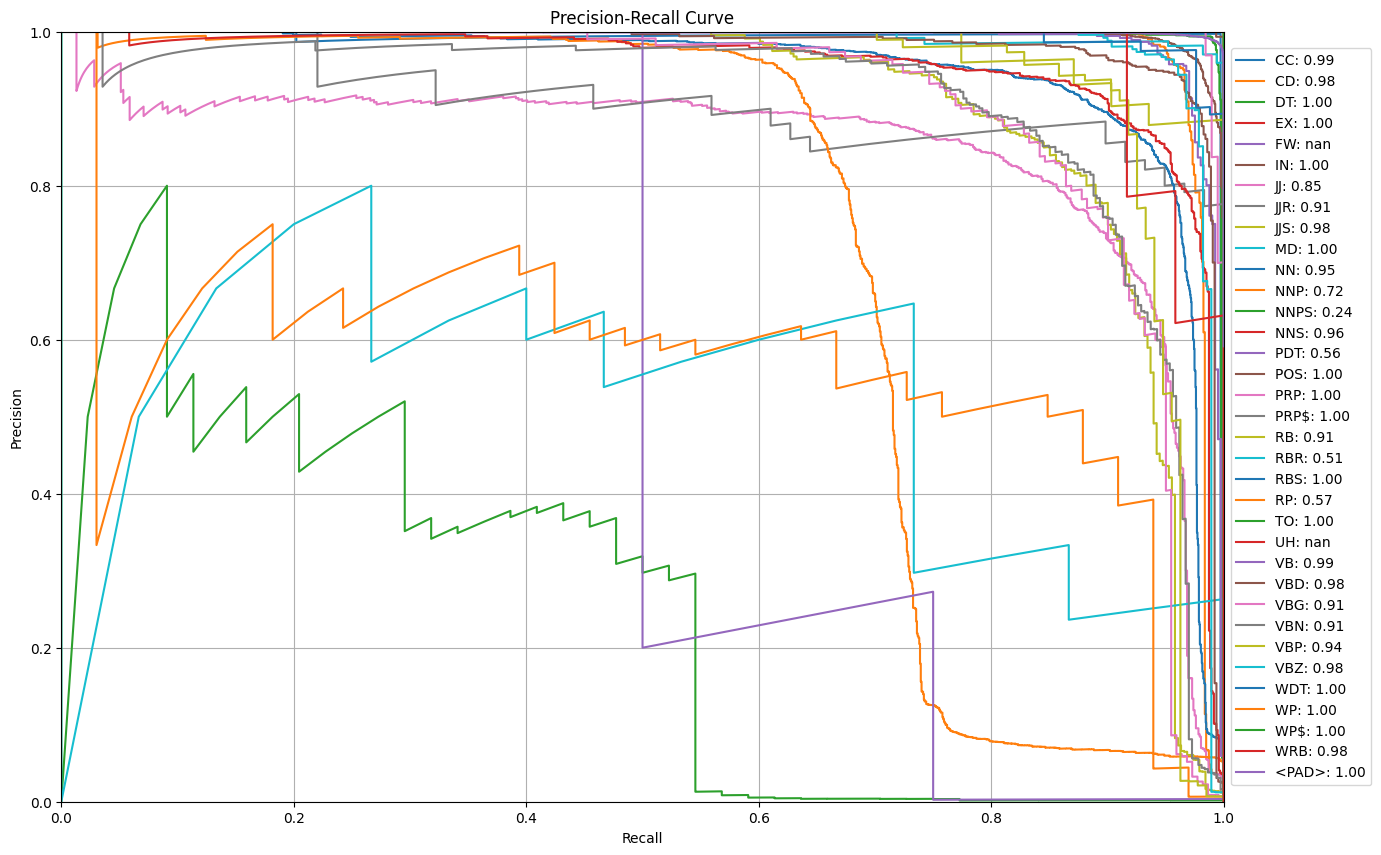

In [450]:
import matplotlib.pyplot as plt
from torchmetrics import PrecisionRecallCurve

precision_curve = PrecisionRecallCurve(task="multiclass", num_classes=best_model.output_dim)

y_pred = torch.Tensor([])
y_true = torch.empty(0, dtype=torch.long) 

for batch in test_loader:
    x_batch, y_true_batch = batch
    y_pred_batch = best_model(x_batch)
    y_pred_batch = y_pred_batch.reshape(-1, best_model.output_dim)
    y_true_batch = y_true_batch.reshape(-1)
    y_pred = torch.cat((y_pred, y_pred_batch), dim=0)
    y_true = torch.cat((y_true, y_true_batch), dim=0)
    

curve = precision_curve(y_pred, y_true)
precision, recall, _ = curve

plt.figure(figsize=(15, 10))
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()


pos_to_auc = {}
for i in range(best_model.output_dim):
    pos_name = pos_vocab.lookup_token(i)
    
    if pos_name in punctuation_and_symbol_pos:
        continue
                
    auc = -1 * torch.trapz(precision[i], recall[i])
    
    pos_to_auc[pos_name] = auc.item()
    
    plt.plot(recall[i], precision[i], label=f"{pos_name}: {auc:.2f}")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


In [451]:

top_k_hardest = 3
hardest = sorted(pos_to_auc.items(), key=lambda x: x[1])[:top_k_hardest]
print(f"Top 3 hardest pos {hardest}")

Top 3 hardest pos [('NNPS', 0.24211819469928741), ('RBR', 0.5132634043693542), ('PDT', 0.5598533749580383)]


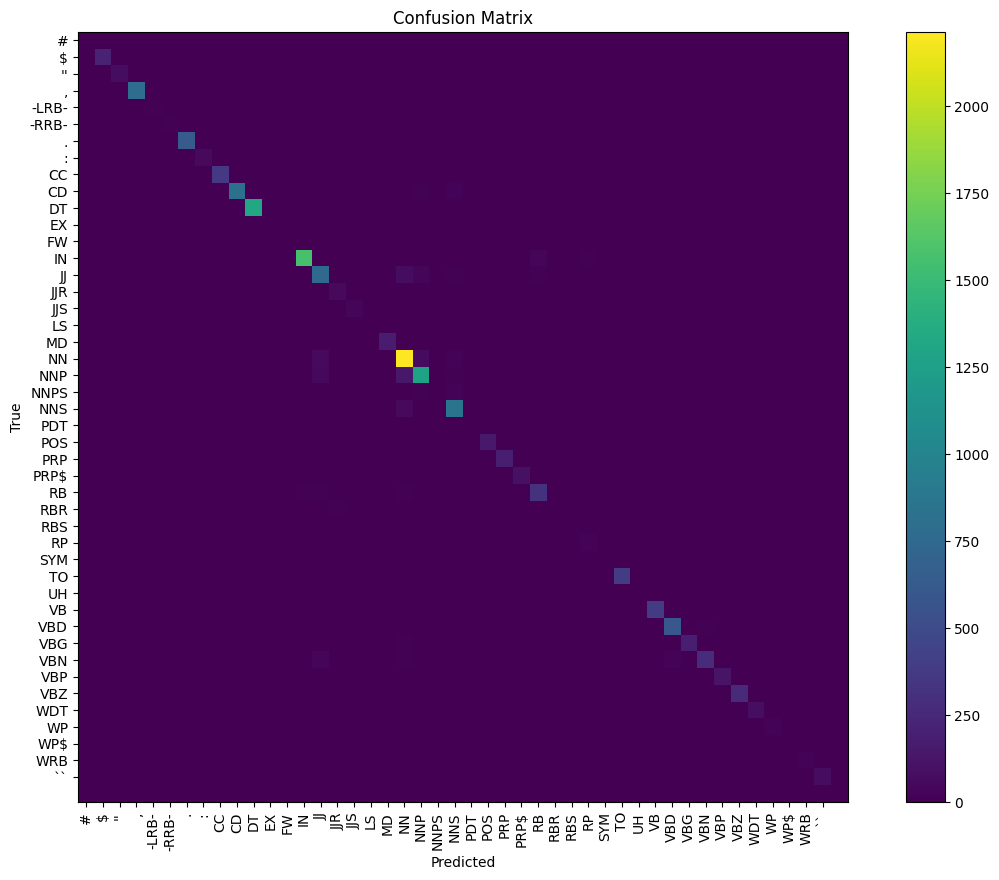

In [452]:
from torchmetrics.classification import MulticlassConfusionMatrix

confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=best_model.output_dim)

y_pred_class = torch.argmax(y_pred, dim=1)
pred_to_plot = y_pred_class[y_true != pos_padding_value]
true_to_plot = y_true[y_true != pos_padding_value]

confusion_matrix = confusion_matrix_metric(pred_to_plot, true_to_plot)

# plot confusion matrix
plt.figure(figsize=(15, 10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.imshow(confusion_matrix)
plt.colorbar()
plt.xticks(range(best_model.output_dim - 1), pos_vocab.get_itos()[:-1])
plt.yticks(range(best_model.output_dim - 1), pos_vocab.get_itos()[:-1])
# x ticks labels vertical
plt.xticks(rotation=90)

plt.show()

In [453]:
# Find the maximum value outside the diagonal

confused_pos = {}
    
for i in range(best_model.output_dim):
    if i in punctuation_and_symbol_pos or i == pos_padding_value:
        continue
        
    temp_row = confusion_matrix[i]
    temp_row[i] = -1
    
    # find the pos that is most confused with the current pos
    max_pos = torch.argmax(temp_row)
    
    confused_pos[pos_vocab.lookup_token(i)] = {
        "confused_with": pos_vocab.lookup_token(max_pos),
        "n_errors": temp_row[max_pos].item()
    }
    
    # print(f"Most confused pos for {pos_vocab.lookup_token(i)} is {pos_vocab.lookup_token(max_pos)}, with {temp_row[max_pos].item()} errors")     

top_k_most_confused = 6
most_confused = sorted(confused_pos.items(), key=lambda x: x[1]["n_errors"], reverse=True)[:top_k_most_confused]

for i, (pos, info) in enumerate(most_confused):
    print(f"Top {i + 1} most confused pos {pos}, confused with {info['confused_with']} with {info['n_errors']} errors")

Top 1 most confused pos NNP, confused with NN with 144 errors
Top 2 most confused pos JJ, confused with NN with 77 errors
Top 3 most confused pos NN, confused with NNP with 65 errors
Top 4 most confused pos NNS, confused with NN with 52 errors
Top 5 most confused pos VBN, confused with JJ with 37 errors
Top 6 most confused pos IN, confused with RB with 35 errors


# Task 7: Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.